In [1]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

# Supplementary functions

In [2]:
import xarray as xr
import numpy as np
import math

## Coordinate functions

In [3]:
def x_coord(array):
    '''
    Returns horizontal coordinate, 'xq' or 'xh'
    as xarray
    '''
    try:
        coord = array.xq
    except:
        coord = array.xh
    return coord

def y_coord(array):
    '''
    Returns horizontal coordinate, 'yq' or 'yh'
    as xarray
    '''
    try:
        coord = array.yq
    except:
        coord = array.yh
    return coord

def remesh(input, target):
    '''
    Input and target should be xarrays of any type (u-array, v-array, q-array, h-array).
    Datasets are prohibited.
    Horizontal mesh of input changes according to horizontal mesh of target.
    Other dimensions are unchanged!

    If type of arrays is different:
        - Interpolation to correct points occurs
    If input is Hi-res:
        - Coarsening with integer grain and subsequent interpolation to correct mesh if needed
    if input is Lo-res:
        - Interpolation to Hi-res mesh occurs

    Input and output Nan values are treates as zeros (see "fillna")
    '''

    # Define coordinates
    x_input  = x_coord(input)
    y_input  = y_coord(input)
    x_target = x_coord(target)
    y_target = y_coord(target)

    # ratio of mesh steps
    ratiox = np.diff(x_target)[0] / np.diff(x_input)[0]
    ratiox = math.ceil(ratiox)

    ratioy = np.diff(y_target)[0] / np.diff(y_input)[0]
    ratioy = math.ceil(ratioy)
    
    # B.C.
    result = input.fillna(0)
    
    if (ratiox > 1 or ratioy > 1):
        # Coarsening; x_input.name returns 'xq' or 'xh'
        result = result.coarsen({x_input.name: ratiox, y_input.name: ratioy}, boundary='pad').mean()

    # Coordinate points could change after coarsegraining
    x_result = x_coord(result)
    y_result = y_coord(result)

    # Interpolate if needed
    if not x_result.equals(x_target) or not y_result.equals(y_target):
        result = result.interp({x_result.name: x_target, y_result.name: y_target}).fillna(0)

    # Remove unnecessary coordinates
    if x_target.name != x_input.name:
        result = result.drop_vars(x_input.name)
    if y_target.name != y_input.name:
        result = result.drop_vars(y_input.name)
    
    return result

## Finite difference operators

In [4]:
def diffy_tu(array,target):
    '''
    finite y-difference of array defined in 
    V points, and result belongs to T (or U) points
    target - T-array to inherit coordinates from
    '''
    p = array.isel(yq=slice(1,None)).rename({'yq':'yh'})
    p['yh'] = target['yh']
    m = array.isel(yq=slice(None,-1)).rename({'yq':'yh'})
    m['yh'] = target['yh']
    return remesh(p-m,target)

def diffx_tv(array,target):
    '''
    finite x-difference of array defined in 
    U points, and result belongs to T (or V) points
    target - T-array to inherit coordinates from
    '''
    p = array.isel(xq=slice(1,None)).rename({'xq':'xh'})
    p['xh'] = target['xh']
    m = array.isel(xq=slice(None,-1)).rename({'xq':'xh'})
    m['xh'] = target['xh']
    return remesh(p-m,target)

def diffx_uq(array,target):
    '''
    finite x-difference of array defined in 
    T points, and result belongs to U (or Q) points
    target - u-array to inherit coordinates from
    '''
    p = array.isel(xh=slice(1,None)).rename({'xh':'xq'})
    p['xq'] = target['xq'].isel(xq=slice(1,-1))
    m = array.isel(xh=slice(None,-1)).rename({'xh':'xq'})
    m['xq'] = target['xq'].isel(xq=slice(1,-1))
    return remesh(p-m,target)

def diffy_vq(array,target):
    '''
    finite y-difference of array defined in 
    T points, and result belongs to V (or Q) points
    target - v-array to inherit coordinates from
    '''
    p = array.isel(yh=slice(1,None)).rename({'yh':'yq'})
    p['yq'] = target['yq'].isel(yq=slice(1,-1))
    m = array.isel(yh=slice(None,-1)).rename({'yh':'yq'})
    m['yq'] = target['yq'].isel(yq=slice(1,-1))
    return remesh(p-m,target)

def prodx_uq(array,target):
    '''
    product in x direction of array defined in 
    T points, and result belongs to U (or Q) points
    target - u-array to inherit coordinates from
    '''
    p = array.isel(xh=slice(1,None)).rename({'xh':'xq'})
    p['xq'] = target['xq'].isel(xq=slice(1,-1))
    m = array.isel(xh=slice(None,-1)).rename({'xh':'xq'})
    m['xq'] = target['xq'].isel(xq=slice(1,-1))
    return remesh(p*m,target)

def prody_vq(array,target):
    '''
    product in y direction of array defined in 
    T points, and result belongs to V (or Q) points
    target - v-array to inherit coordinates from
    '''
    p = array.isel(yh=slice(1,None)).rename({'yh':'yq'})
    p['yq'] = target['yq'].isel(yq=slice(1,-1))
    m = array.isel(yh=slice(None,-1)).rename({'yh':'yq'})
    m['yq'] = target['yq'].isel(yq=slice(1,-1))
    return remesh(p*m,target)

## Arakawa-Sadourny numerical scheme
https://mom6.readthedocs.io/en/dev-gfdl/api/generated/pages/Governing_Equations.html

In [31]:
def KE_Arakawa(u, v, param):
        '''
        https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L1000-L1003
        '''
        areaCu = param.dxCu * param.dyCu
        areaCv = param.dxCv * param.dyCv
        areaT = param.dxT * param.dyT
        return 0.5 * (remesh(areaCu*u**2, areaT) + remesh(areaCv*v**2, areaT)) / areaT

def gradKE(u, v, param):
        '''
        https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L1029-L1034
        '''
        KE = KE_Arakawa(u, v, param)
        IdxCu = 1. / param.dxCu
        IdyCv = 1. / param.dyCv

        KEx = diffx_uq(KE, IdxCu) * IdxCu
        KEy = diffy_vq(KE, IdyCv) * IdyCv
        return (KEx, KEy)

def relative_vorticity(u, v, param):
    '''
    https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L472
    '''
    dyCv = param.dyCv
    dxCu = param.dxCu
    IareaBu = 1. / (param.dxBu * param.dyBu)
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L309-L310
    dvdx = diffx_uq(v*dyCv,IareaBu)
    dudy = diffy_vq(u*dxCu,IareaBu)
    return (dvdx - dudy) * IareaBu

def PV_cross_uv(u, v, h, param):
    '''
    https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L669-L671
    https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L788-L790
    fx = + q * vh
    fy = - q * uh
    '''
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L131
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_continuity_PPM.F90#L569-L570
    uh = u * remesh(h,u) * param.dyCu
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L133
    vh = v * remesh(h,v) * param.dxCv
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L484
    rel_vort = relative_vorticity(u, v, param)

    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L247
    Area_h = param.dxT * param.dyT
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L272-L273
    Area_q = remesh(Area_h, rel_vort) * 4
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L323
    hArea_u = remesh(Area_h*h,uh)
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L320
    hArea_v = remesh(Area_h*h,vh)
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L488
    hArea_q = 2*remesh(hArea_u,rel_vort) + 2*remesh(hArea_v,rel_vort)
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L489
    Ih_q = Area_q / hArea_q

    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L490
    q = rel_vort * Ih_q

    IdxCu = 1. / param.dxCu
    IdyCv = 1. / param.dyCv
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L669-L671
    CAu = + remesh(q * remesh(vh,q),IdxCu) * IdxCu
    # https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L788-L790
    CAv = - remesh(q * remesh(uh,q),IdyCv) * IdyCv

    return (CAu, CAv)

def advection(u, v, h, param):
    '''
    https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L751
    https://github.com/NOAA-GFDL/MOM6/blob/dev/gfdl/src/core/MOM_CoriolisAdv.F90#L875
    '''
    CAu, CAv = PV_cross_uv(u, v, h, param)
    KEx, KEy = gradKE(u, v, param)
    return (CAu - KEx, CAv - KEy)

## Simplest numerical scheme

In [64]:
# For debugging reasons
# def advection_simple(u, v, RV, h, param):
#     '''
#     Computes
#     fx = + RV * v - dKE/dx
#     fy = - RV * u - dKE/dy
#     '''
#     KE = 0.5 * (remesh(u**2, h) + remesh(v**2,h))
#     IdxCu = 1. / param.dxCu
#     IdyCv = 1. / param.dyCv
#     KEx = diffx_uq(KE, IdxCu) * IdxCu
#     KEy = diffy_vq(KE, IdyCv) * IdyCv
    
#     fx = + remesh(RV, u) * remesh(v, u) - KEx
#     fy = - remesh(RV, v) * remesh(u, v) - KEy
#     return fx, fy

## Filter functions

In [6]:
def simple_coarsegraining(input_array, coordinate_array):
    '''
    input_array - xr.DataArray() on high-resolution grid
    coordinate_array - any xr.DataArray() containing target coordinates;
    returns filtered and coarsegrained version of input_field
    '''
    print('Simple coarsegraining is used')
    return remesh(input_array, coordinate_array)

In [145]:
import gcm_filters
def gaussian_and_coarsegraining(input_array, coordinate_array, FGR=2):
    '''
    input_array - xr.DataArray() on high-resolution grid
    coordinate_array - any xr.DataArray() containing target coordinates;
    returns filtered and coarsegrained version of input_field
    '''
    # Define grid ratio
    ratio = math.ceil(np.diff(x_coord(coordinate_array))[0] / np.diff(x_coord(input_array))[0])
    # Make filter scale proportional to grid ratio
    G = gcm_filters.Filter(filter_scale = ratio * FGR, dx_min=1) 
    
    # Find spatial coordinates
    x = 'xh' if 'xh' in input_array.dims else 'xq'
    y = 'yh' if 'yh' in input_array.dims else 'yq'    
    
    # Filter
    filtered = G.apply(input_array, dims=(y,x))
    
    # Coarsegrain
    coarsegrained = remesh(filtered, coordinate_array)
    
    print(f'Gaussian filter and coarsegraining. Grid steps ratio:{ratio}, Filter scale:{ratio*FGR}')
    if (ratio*FGR > 16):
        print('Warning: It is likely that gcm filters do not work properly. Check the filter.')
    
    return coarsegrained

# Class for computation of subgrid forcing

In [60]:
class SubgridForcing():
    def __init__(self, prog, param_hires):
        '''
        prog - xr.Dataset() representing files prog*.nc of high-resolution
        simulation
        param_hires - xr.Dataset() representing ocean_geometry.nc of high-resolution model
        '''
        self.prog = prog
        # change coordinates notation as in other files
        self.param_hires = param_hires.rename({'latq': 'yq', 'lonq': 'xq', 'lath': 'yh', 'lonh': 'xh'})
        return
    
    def compute_subgrid_forcing(self, param, filter_coarsegrain=simple_coarsegraining):
        '''
        Revieves:
        * param - ocean_geometry.nc of coarse model
        * filter-coarsegrain function
        Algorithm: 
        * Filter and coarsegrain u, v and h
        * Compute advection on high-res and low-res data
        * Returns subgrid forcing and coarse u,v,h into class fields
        '''
        
        # Initialize param file
        param_lores = param.rename({'latq': 'yq', 'lonq': 'xq', 'lath': 'yh', 'lonh': 'xh'})
        
        ds = xr.Dataset()
        
        # Coarsegraining-filtering data
        ds['u'] = filter_coarsegrain(self.prog.u,param_lores.dxCu) 
        ds['v'] = filter_coarsegrain(self.prog.v,param_lores.dxCv)
        ds['h'] = filter_coarsegrain(self.prog.h,param_lores.dxT)
        
        # Computing advection on two grids
        advection_hires = advection(self.prog.u, self.prog.v, self.prog.h, self.param_hires)
        advection_lores = advection(ds['u'], ds['v'], ds['h'], param_lores)
        
        # Subgrid forcing
        ds['SGSx'] = filter_coarsegrain(advection_hires[0], param_lores.dxCu) - advection_lores[0]
        ds['SGSy'] = filter_coarsegrain(advection_hires[1], param_lores.dxCv) - advection_lores[1]
        return ds#, advection_hires, advection_lores
        

# Read data and compute

In [61]:
prog = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R64/output/prog*', decode_times=False, parallel=True, chunks={'Time': 1})
param_hires = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R64/output/ocean_geometry.nc')
param_R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R4/output/ocean_geometry.nc')
param_R8 = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R8/output/ocean_geometry.nc')

In [62]:
SGS = SubgridForcing(prog, param_hires)

In [65]:
R4 = SGS.compute_subgrid_forcing(param_R4)

Simple coarsegraining is used
Simple coarsegraining is used
Simple coarsegraining is used
Simple coarsegraining is used
Simple coarsegraining is used


# Comparison to data on /scratch/zanna

In [66]:
ref = xr.open_mfdataset('/scratch/zanna/MOM6-Double-Gyre-subgrid-forcing/R4.nc', decode_times=False, chunks={'Time': 1})

In [67]:
Time = 5
for key in ['u', 'v', 'SGSx', 'SGSy']:
    error = ((ref[key] - R4[key])**2).isel(Time=Time).mean() / ((ref[key])**2).isel(Time=Time).mean()
    print(f'Relative error in {key}', float(error))

Relative error in u 5.866050443244404e-16
Relative error in v 6.438700302125475e-16
Relative error in SGSx 6.592109030363144e-16
Relative error in SGSy 4.186355938564231e-16


# Using GCM filters

In [133]:
prog = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R32/output/prog*', decode_times=False, parallel=True, chunks={'Time': 1})
param_hires = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R32/output/ocean_geometry.nc')
param_R4 = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R4/output/ocean_geometry.nc')
param_R8 = xr.open_mfdataset('/scratch/pp2681/mom6/Feb2022/bare/R8/output/ocean_geometry.nc')

In [134]:
SGS = SubgridForcing(prog, param_hires)

In [146]:
R4_coarsegrain = SGS.compute_subgrid_forcing(param_R4)

Simple coarsegraining is used
Simple coarsegraining is used
Simple coarsegraining is used
Simple coarsegraining is used
Simple coarsegraining is used


In [147]:
R8_coarsegrain = SGS.compute_subgrid_forcing(param_R8)

Simple coarsegraining is used
Simple coarsegraining is used
Simple coarsegraining is used
Simple coarsegraining is used
Simple coarsegraining is used


In [148]:
R4_gauss = SGS.compute_subgrid_forcing(param_R4, gaussian_and_coarsegraining)

Gaussian filter and coarsegraining. Grid steps ratio:8, Filter scale:16
Gaussian filter and coarsegraining. Grid steps ratio:8, Filter scale:16
Gaussian filter and coarsegraining. Grid steps ratio:8, Filter scale:16
Gaussian filter and coarsegraining. Grid steps ratio:8, Filter scale:16
Gaussian filter and coarsegraining. Grid steps ratio:8, Filter scale:16


In [149]:
R8_gauss = SGS.compute_subgrid_forcing(param_R8, gaussian_and_coarsegraining)

Gaussian filter and coarsegraining. Grid steps ratio:4, Filter scale:8
Gaussian filter and coarsegraining. Grid steps ratio:4, Filter scale:8
Gaussian filter and coarsegraining. Grid steps ratio:4, Filter scale:8
Gaussian filter and coarsegraining. Grid steps ratio:4, Filter scale:8
Gaussian filter and coarsegraining. Grid steps ratio:4, Filter scale:8


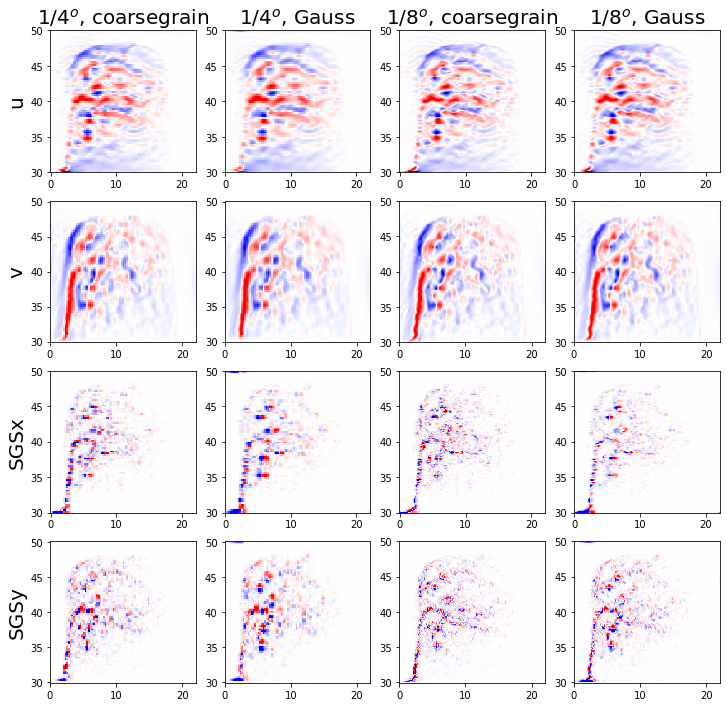

In [179]:
idx = {'Time': -1, 'zl': 0}
plt.figure(figsize=(12,12), facecolor='white')
for col, ds in enumerate([R4_coarsegrain, R4_gauss, R8_coarsegrain, R8_gauss]):
    for row, key in enumerate(['u', 'v', 'SGSx', 'SGSy']):
        plt.subplot(4,4,1+col + 4*row)
        var = ds[key].isel(idx)
        var.plot(add_colorbar=False, cmap='bwr', vmin=-5*float(var.std()))
        plt.xlabel(''); plt.ylabel(''); plt.title('')
        
plt.subplot(4,4,1); plt.title('$1/4^o$, coarsegrain', fontsize=20)
plt.subplot(4,4,2); plt.title('$1/4^o$, Gauss', fontsize=20)
plt.subplot(4,4,3); plt.title('$1/8^o$, coarsegrain', fontsize=20)
plt.subplot(4,4,4); plt.title('$1/8^o$, Gauss', fontsize=20)

plt.subplot(4,4,1); plt.ylabel('u', fontsize=20)
plt.subplot(4,4,5); plt.ylabel('v', fontsize=20)
plt.subplot(4,4,9); plt.ylabel('SGSx', fontsize=20)
plt.subplot(4,4,13); plt.ylabel('SGSy', fontsize=20)

plt.savefig('subgrid_forcing.png', dpi=300)

# Energy cospectrum

In [180]:
import xrft

In [181]:
def select_LatLon(array, Lat=(35,45), Lon=(5,15)):
    '''
    array is xarray
    Lat, Lon = tuples of floats
    '''
    x = x_coord(array)
    y = y_coord(array)

    return array.sel({x.name: slice(Lon[0],Lon[1]), 
                      y.name: slice(Lat[0],Lat[1])})

In [182]:
def compute_isotropic_cospectrum(u_in, v_in, fu_in, fv_in, dx, dy, Lat=(35,45), Lon=(5,15), window='hann', 
        nfactor=2, truncate=False, detrend='linear', window_correction=True):
    # Interpolate to the center of the cells
    u = remesh(u_in, dx)
    v = remesh(v_in, dy)
    fu = remesh(fu_in.transpose(*u_in.dims), dx)
    fv = remesh(fv_in.transpose(*v_in.dims), dy)

    # Select desired Lon-Lat square
    u = select_LatLon(u,Lat,Lon)
    v = select_LatLon(v,Lat,Lon)
    fu = select_LatLon(fu,Lat,Lon)
    fv = select_LatLon(fv,Lat,Lon)

    # mean grid spacing in metres
    dx = select_LatLon(dx,Lat,Lon).mean().values
    dy = select_LatLon(dy,Lat,Lon).mean().values

    # define uniform grid
    x = dx*np.arange(len(u.xh))
    y = dy*np.arange(len(u.yh))
    for variable in [u, v, fu, fv]:
        variable['xh'] = x
        variable['yh'] = y

    Eu = xrft.isotropic_cross_spectrum(u, fu, dim=('xh','yh'), window=window, nfactor=nfactor, 
        truncate=truncate, detrend=detrend, window_correction=window_correction)
    Ev = xrft.isotropic_cross_spectrum(v, fv, dim=('xh','yh'), window=window, nfactor=nfactor, 
        truncate=truncate, detrend=detrend, window_correction=window_correction)

    E = (Eu+Ev)
    E['freq_r'] = E['freq_r']*2*np.pi # because library returns frequencies, but not wavenumbers
    
    return np.real(E)

In [190]:
def cosp(ds, param):
    return compute_isotropic_cospectrum(ds.u, ds.v, ds.SGSx, ds.SGSy, param.dxT.rename({'lonh':'xh', 'lath': 'yh'}), param.dyT.rename({'lonh':'xh', 'lath': 'yh'}))

In [191]:
cosp_R4 = cosp(R4_coarsegrain, param_R4)
cosp_gauss_R4 = cosp(R4_gauss, param_R4)
cosp_R8 = cosp(R8_coarsegrain, param_R8)
cosp_gauss_R8 = cosp(R8_gauss, param_R8)

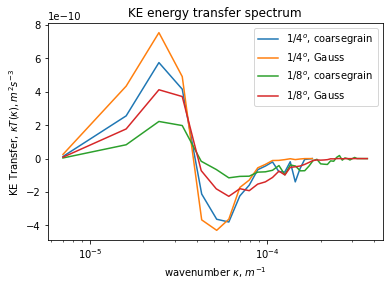

In [203]:
op = lambda x: x['freq_r']*x.isel(Time=slice(-10,None),zl=0).mean('Time')
op(cosp_R4).plot(label='$1/4^o$, coarsegrain')
op(cosp_gauss_R4).plot(label='$1/4^o$, Gauss')
op(cosp_R8).plot(label='$1/8^o$, coarsegrain')
op(cosp_gauss_R8).plot(label='$1/8^o$, Gauss')
plt.legend()
plt.xscale('log')
plt.xlabel('wavenumber $\kappa$, $m^{-1}$')
plt.ylabel('KE Transfer, $\kappa T(\kappa), m^2s^{-3}$')
plt.title('KE energy transfer spectrum')
plt.savefig('Transfer.pdf')